In [ ]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
import cv2

model = load_model("groundingdino/config/GroundingDINO_SwinT_OGC.py", "weights/groundingdino_swint_ogc.pth")
IMAGE_PATH = ".asset/cat_dog.jpeg"
TEXT_PROMPT = "chair . person . dog ."
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
cv2.imwrite("annotated_image.jpg", annotated_frame)

final text_encoder_type: bert-base-uncased


True

: 

In [46]:
import torch
from collections import defaultdict
import numpy as np
import lap
def linear_assignment(cost_matrix, thresh):
    if cost_matrix.size == 0:
        return np.empty((0, 2), dtype=int), np.arange(cost_matrix.shape[0], dtype=int), np.arange(cost_matrix.shape[1], dtype=int)
    matches, unmatched_a, unmatched_b = [], [], []
    cost, x, y = lap.lapjv(cost_matrix, extend_cost=True, cost_limit=thresh)
    print(x,y)
    for ix, mx in enumerate(x):
        if mx >= 0:
            matches.append([ix, mx])
    unmatched_a = np.where(x < 0)[0]
    unmatched_b = np.where(y < 0)[0]
    matches = np.asarray(matches) if len(matches) > 0 else np.empty((0, 2), dtype=np.int64)
    return matches, unmatched_a, unmatched_b

cost_matrix = np.array([[0.8, 0.2, 0.9], [0.4, 0.8, 0.6]])
thresh = 0.1
matches, unmatched_a, unmatched_b = linear_assignment(1-cost_matrix, thresh)
a = np.empty((0, 1))
print(a)
print("matrix:", 1- cost_matrix)
print("Matches:", matches)
print("Unmatched A:", unmatched_a)
print("Unmatched B:", unmatched_b)

[ 2 -1] [-1 -1  0]
[]
matrix: [[0.2 0.8 0.1]
 [0.6 0.2 0.4]]
Matches: [[0 2]]
Unmatched A: [1]
Unmatched B: [0 1]


In [1]:
import torch
import torch.nn as nn

m = nn.Dropout(p=0.5)
input = torch.randn(2, 1)
output = m(input)
print(input.shape)
print(input[:, None].shape)
print(output)
a = [1,2,3,4,5,6]
print(a[4])
print(a[4:5])

torch.Size([2, 1])
torch.Size([2, 1, 1])
tensor([[-1.1251],
        [ 0.0000]])
5
[5]


[02/27 14:31:28] root ERROR: Did not merge any categories.


[55]
[{'id': 64164, 'video': 'train/LaSOT/boat-9', '_scale_task_id': '5dad9b0ea6e4543773ab1488', 'width': 1280, 'height': 720, 'file_name': 'train/LaSOT/boat-9/00001441.jpg', 'frame_index': 1440, 'license': 0, 'video_id': 1699, 'frame_id': 36, 'neg_category_ids': [862, 1004, 299], 'not_exhaustive_category_ids': []}]
[{'segmentation': [[97, 168, 172, 168, 172, 237, 97, 237]], 'bbox': [97.0, 168.0, 75.0, 69.0], 'area': 5175, 'iscrowd': 0, 'id': 238306, 'image_id': 64164, 'category_id': 793, 'track_id': 11007, '_scale_uuid': 'bf625a09-4f43-4274-8711-9259d4d5775f', 'scale_category': 'person', 'video_id': 1699, 'instance_id': 11007}]


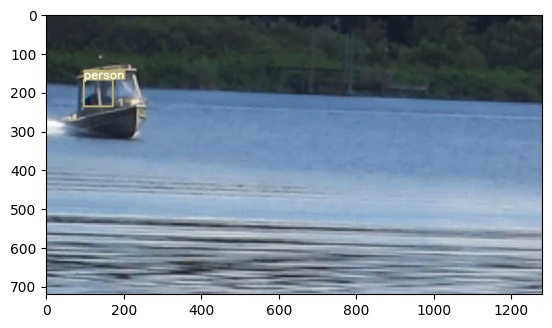

In [7]:
import torch
import os.path as osp
import numpy as np
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
from groundingdino.util import box_ops, get_tokenlizer
from tao.toolkit.tao import Tao
import cv2

np.random.seed(4)

def plot_bbox(img, bbox, label):
    tl = 3
    color = tuple(np.random.randint(0, 255, size=3).tolist())
    bbox[2] += bbox[0]
    bbox[3] += bbox[1]
    c1, c2 = (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1)  # filled
        cv2.putText(img,
                    label, (c1[0], c1[1] - 2),
                    0,
                    tl / 3, [225, 255, 255],
                    thickness=tf,
                    lineType=cv2.LINE_AA)
    
    return img

ann_path = '/data/fzm_2022/Datasets/TAO/annotations/train_ours_v1.json'
tao = Tao(ann_path)
imgid_list = tao.get_img_ids()
vidid_list = tao.get_vid_ids()
idx = 55
img_id = 64164
print([imgid_list[idx]])
img_info = tao.load_imgs([img_id])
print(img_info)
target = tao.img_ann_map[img_id]
print(target)
category_dict = tao.cats
cat_list = [item['name'] for item in category_dict.values()]
# print(cat_list[643])
no_l = img_info[0]['not_exhaustive_category_ids']
no_cat = [cat_list[item-1] for item in no_l]
img_path = osp.join('/data/fzm_2022/Datasets/TAO/frames',img_info[0]['file_name'])
img = cv2.imread(img_path)
w, h = img.shape[1], img.shape[0]
cat_dic = defaultdict(list)
for item in target:
    cat_dic[cat_list[item['category_id']-1]].append(item['bbox'])
    plot_bbox(img, item['bbox'], cat_list[item['category_id']-1])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# print(img_path)
# cat_list = cat_dic.keys()
# caption = " . ".join(cat_list) + ' .'
# print(caption)


##### AED测试格式
``` txt
[
    {
        "image_id": 80,
        "category_id": 644,
        "bbox": [
            0.0,
            374.5414733886719,
            155.56817626953125,
            105.45281982421875
        ],
        "score": 0.85207200050354,
        "track_id": 0,
        "video_id": 2,
        "is_new": true
    },
]
```

In [30]:
from groundingdino.util import box_ops, get_tokenlizer
text_encoder_type="bert-base-uncased"
tokenizer = get_tokenlizer.get_tokenlizer(text_encoder_type)
caption = 'person . iPad .'
tokenized = tokenizer(caption, padding="longest", return_tensors="pt")
beg = tokenized.char_to_token(15)
print(beg)
print(tokenized)

final text_encoder_type: bert-base-uncased
None
{'input_ids': tensor([[  101,  2711,  1012, 25249,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


In [20]:
from tao.toolkit.tao import Tao

ann_path = '/data/fzm_2022/Datasets/TAO/annotations/train_ours_v1.json/'
# tao = Tao(ann_path)
# vids = tao.vids
# vid_img = tao.vid_img_map
# print(len(vid_img[0]))

ann_str = ann_path.split(' ')
print(ann_str)


['/data/fzm_2022/Datasets/TAO/annotations/train_ours_v1.json/']


In [4]:
import random


cat_cl_names = {'person': 1, 'dog_tt':2, 'cat_aa(de)':5}

def build_captions_and_token_span(cat_dict, force_lowercase):

    cat2tokenspan = {}
    captions = ""
    cat_list = list(cat_dict.keys())
    
    for catname in cat_list:
        if force_lowercase:
            catname = catname.lower()

        tokens_positive_i = []
        subnamelist = [i.strip() for i in catname.split("(")[0].replace("_", " ").split(" ")]
        for subname in subnamelist:
            if len(subname) == 0:
                continue
            if len(captions) > 0:
                captions = captions + " "
            strat_idx = len(captions)
            end_idx = strat_idx + len(subname)
            tokens_positive_i.append([strat_idx, end_idx])
            captions = captions + subname

        if len(tokens_positive_i) > 0:
            captions = captions + " ."
            cat2tokenspan[catname] = tokens_positive_i

    return captions, cat2tokenspan

captions, cat2tokenspan = build_captions_and_token_span(cat_cl_names, force_lowercase=True)
print(captions)
print(cat2tokenspan.values())

person . dog tt . cat aa .
dict_values([[[0, 6]], [[9, 12], [13, 15]], [[18, 21], [22, 24]]])


In [ ]:
a = tensor([[0.5484, 0.4729, 0.1141, 0.3264],
            [0.5094, 0.5729, 0.0641, 0.0903]], device='cuda:0')